# Práctica 2 de Reconocimiento de Patrones:
## Mejoramiento de la Imagen

Integrantes:
 - Diego Fernández Chaparro Plata Javier
 - Velázquez Sánchez José Antonio
 - Vargas Castro Daniel
 
### Objetivos
El alumno:
 - Aprenderá a mejorar la imagen de acuerdo a las modificaciones que se  le realizan original mente
 - Entenderá aumentar las características de contraste, perfilado que apoyen a una mejor medición
 
### Introducción

### Desarrollo

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import skimage
from skimage import io
import scipy.signal
from skimage.filters import threshold_otsu, threshold_adaptive
from skimage.filters import threshold_mean
from collections import deque
import math

In [2]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 10) # Tamaño de los plots, supuestamente en pulgadas (no poner numeros grandes)

Populating the interactive namespace from numpy and matplotlib


#### A) Revertir contraste y corrección de ruido

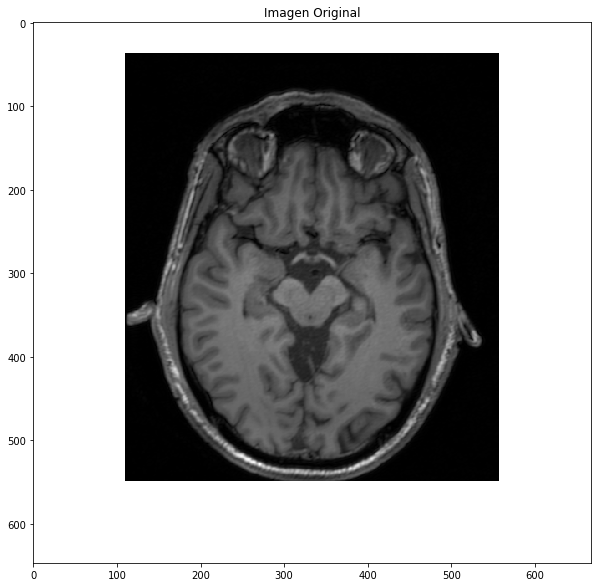

In [44]:
# Imagen Original
original = io.imread("imagenes/midbrain.png", as_gray=True)
plt.imshow(original, cmap='gray', vmin = 0, vmax = 1)
plt.title("Imagen Original")
plt.show()

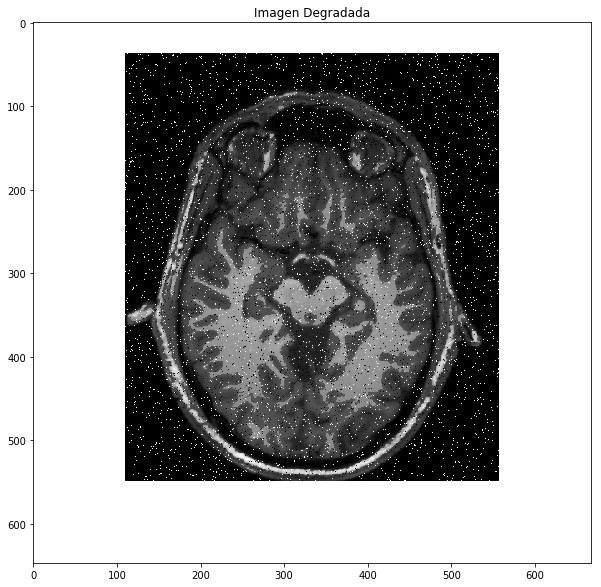

In [4]:
# Imagen Degradada
degraded = io.imread("imagenes/midbrainDegraded.png", as_gray=True)
plt.imshow(degraded, cmap='gray', vmin = 0, vmax = 1)
plt.title("Imagen Degradada")
plt.show()

In [5]:
# Función que se aplicó para cambiar el contraste en la imagen original
def change(original):
    changed = np.array(original, copy=True)
    for i in range(original.shape[0]):
        for j in range(original.shape[1]):
            origpx = original[i][j]
            if origpx < 0.4:
                changed[i][j] = (5.0/8.0)*origpx
            elif (origpx > 0.4 and origpx < 0.6):
                changed[i][j] = origpx
            else:
                changed[i][j] = (3.0/8.0)*origpx + (3.0/8.0)    
    return changed

In [6]:
# Función para corregir el contraste en la imagen degradada
def revert(modified):
    reverted = np.array(modified, copy=True)
    for i in range(modified.shape[0]):
        for j in range(modified.shape[1]):
            modipx = modified[i][j]
            if modipx < 0.4:
                reverted[i][j] = (8.0/5.0)*modipx
            elif (modipx > 0.4 and modipx < 0.6):
                reverted[i][j] = modipx
            else:
                reverted[i][j] = (8.0/3.0)*modipx - 1.0
    return reverted

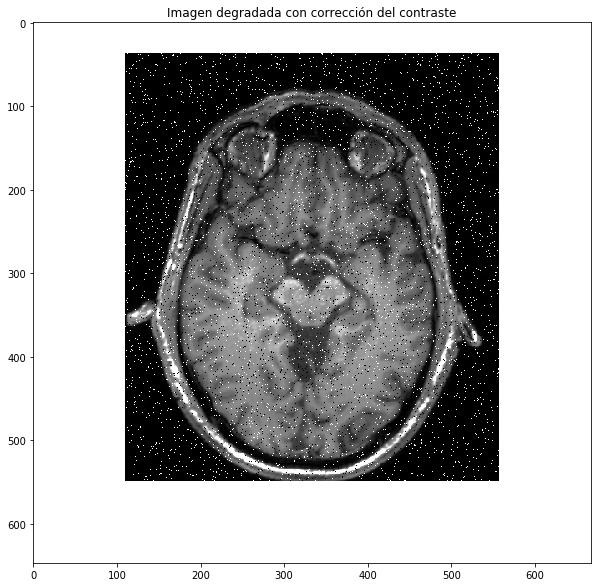

In [7]:
# Corrección del contraste
revertcolors = revert(degraded)
plt.imshow(revertcolors, cmap='gray', vmin = 0, vmax = 1)
plt.title("Imagen degradada con corrección del contraste")
plt.show()

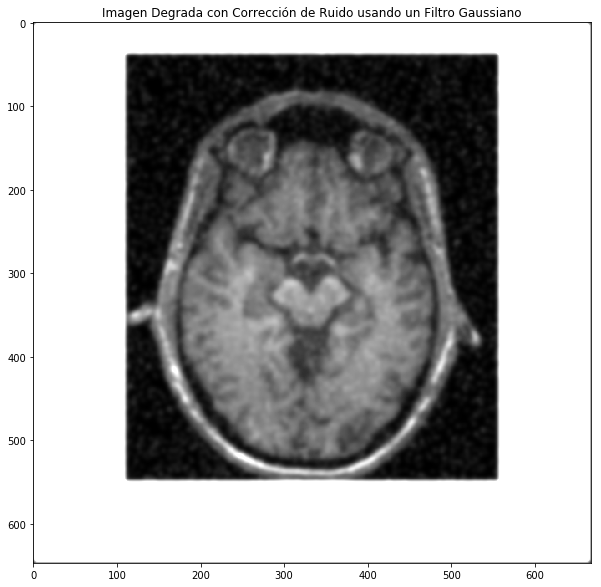

In [31]:
# Corrección del Ruido
v = [1,10,45,120,210,252,210,120,45,10,1]
blur_kernel = np.outer(v, v)
blur_kernel = blur_kernel / np.sum(blur_kernel)

denoised = revertcolors
for _ in range(3):
    denoised = scipy.signal.convolve2d(denoised, blur_kernel, "same")
plt.imshow(denoised, cmap='gray', vmin = 0, vmax = 1)
plt.title("Imagen Degrada con Corrección de Ruido usando un Filtro Gaussiano")
plt.show()

#### B) Comparar con imagen perfilada

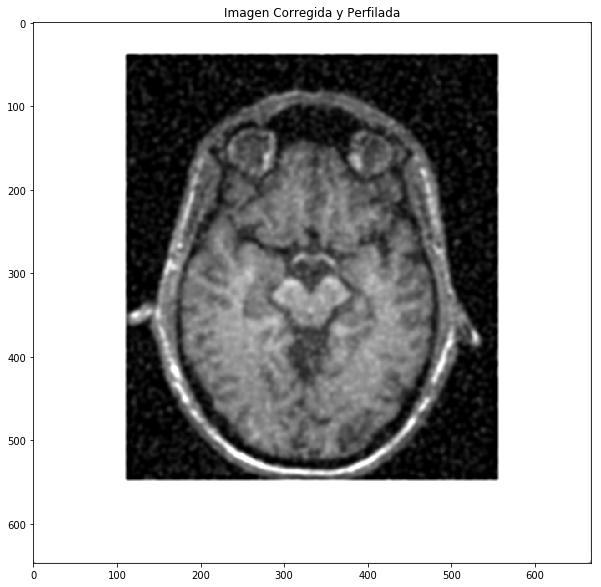

In [32]:
# Filtro de perfilado
identity_filter = np.zeros((11,11))
identity_filter[5][5] = 1

k = 3
profiling_filter = identity_filter + k*(identity_filter - blur_kernel)

profiled = scipy.signal.convolve2d(denoised, profiling_filter, "same")
plt.imshow(profiled, cmap='gray', vmin = 0, vmax = 1)
plt.title("Imagen Corregida y Perfilada")
plt.show()

#### C) Clasificación del mesencéfalo
Para la clasificación del mesencéfalo utilizamos una técnica de segmentación llamada "Region Growing", con la cual escogemos un pixel de la imagen, y a partir de ahí el algoritmo crece una región a la cual corresponde dicho pixel. En nuestro caso, simplemente escogemos un punto del mesencéfalo.

Para poder aplicar esta técnica, es necesario modificar los valores de intensidad de la imagen para que exista mayor contraste entre regiones diferentes.

In [9]:
def mychange(original):
    changed = np.array(original, copy=True)
    for i in range(original.shape[0]):
        for j in range(original.shape[1]):
            origpx = original[i][j]
            if origpx > 0.4:
                changed[i][j] = 1.5*origpx
            else:
                changed[i][j] = 0.666*origpx    
    return changed

In [10]:
def neighbours(pixel):
    neighs = []
    xp1 = pixel.copy()
    xp1[1] = xp1[1] + 1
    neighs.append(xp1)
    xp2 = pixel.copy()
    xp2[0] = xp2[0]+1
    xp2[1] = xp2[1]+1
    neighs.append(xp2)
    
    xp3 = pixel.copy()
    xp3[0] = xp3[0]+1
    neighs.append(xp3)
    
    xp4 = pixel.copy()
    xp4[0] = xp4[0]+1
    xp4[1] = xp4[1]-1
    neighs.append(xp4)
    
    xp5 = pixel.copy()
    xp5[1] = xp5[1]-1
    neighs.append(xp5)
    
    xp6 = pixel.copy()
    xp6[0] = xp6[0]-1
    xp6[1] = xp6[1]-1
    neighs.append(xp6)
    
    xp7 = pixel.copy()
    xp7[0] = xp7[0]-1
    neighs.append(xp7)
    
    xp8 = pixel.copy()
    xp8[0] = xp8[0]-1
    xp8[1] = xp8[1]+1
    neighs.append(xp8)
    return neighs

In [11]:
def distneighs(pixel, image):
    pixval = image[pixel[0], pixel[1]]
    neighs = neighbours(pixel)
    #print("sus vecinos son: ", neighs)
    distance = 0.0
    for elem in neighs:
        elemval = image[elem[0], elem[1]]
        distance += (pixval-elemval)**2
    return math.sqrt(distance)

In [12]:
def reggrow(image, seedpix, threshold):
    new_image = np.array(image, copy=True)
    pixset = set()
    qu = deque([])
    qu.append(seedpix)
    while qu:
        act = qu.pop()
        distance = distneighs(act, denoised)
        if(distance < threshold):
            new_image[act[0], act[1]] = 1
            pixset.add(tuple(act))
            for elem in neighbours(act):
                if tuple(elem) not in pixset:
                    qu.append(elem)
    clean_image = np.array(new_image, copy=True)
    for i in range(clean_image.shape[0]):
        for j in range(clean_image.shape[1]):
            if(clean_image[i][j] != 1):
                clean_image[i][j] = 0
    return clean_image

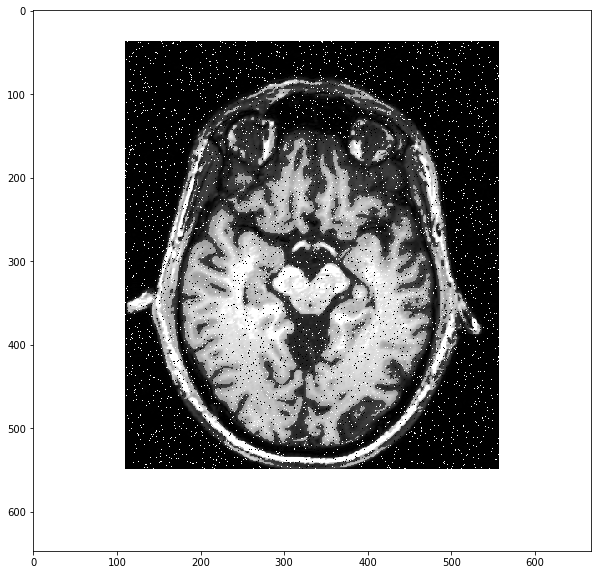

In [52]:
mychanged = mychange(revertcolors)
plt.imshow(mychanged, cmap='gray', vmin = 0, vmax = 1)
plt.show()

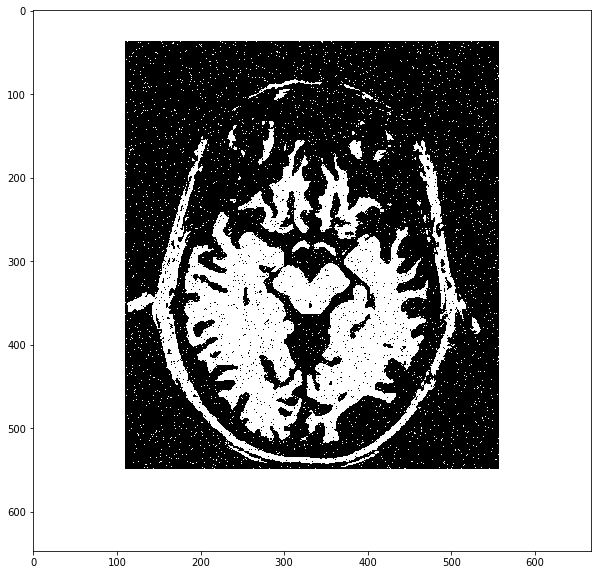

In [53]:
threshimage = mychanged > 0.65
plt.imshow(threshimage, cmap='gray', vmin = 0, vmax = 1)
plt.show()

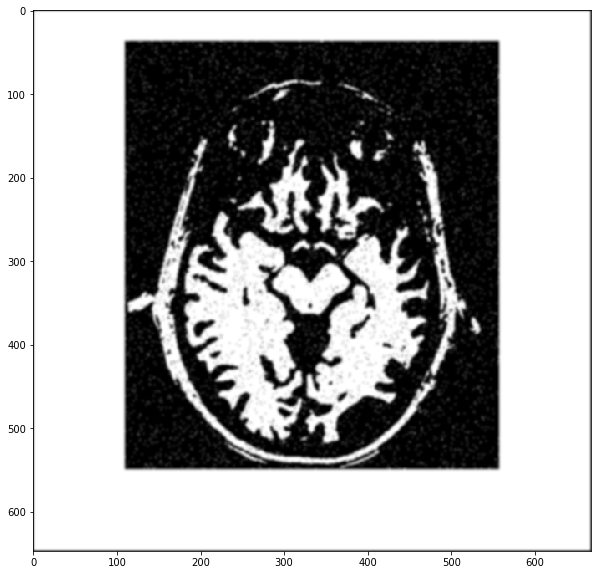

In [54]:
blur_kernel = np.array([[1,1,1],[1,1,1],[1,1,1]])/9.0;
denoised = np.array(threshimage, copy=True)
for i in range(3):
    denoised = scipy.signal.convolve2d(denoised, blur_kernel, "same")
plt.imshow(denoised, cmap='gray', vmin = 0, vmax = 1)
plt.show()

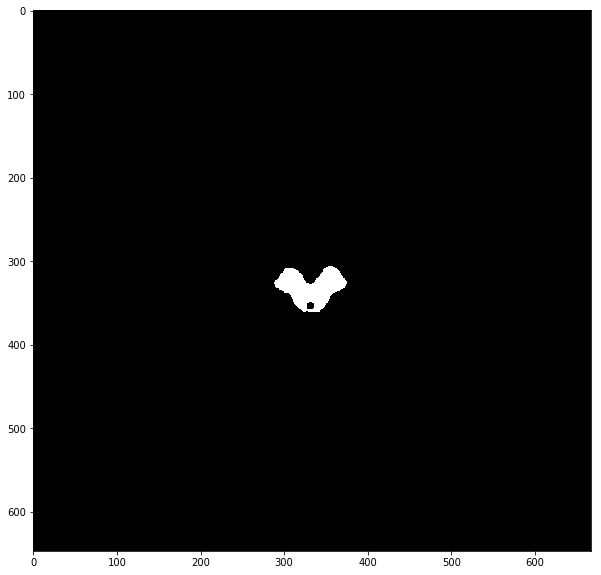

In [56]:
newimage = reggrow(denoised, [327,339], 0.2)
plt.imshow(newimage, cmap='gray', vmin = 0, vmax = 1)
plt.show()

#### D) Mediciones

In [78]:
def mediciones(imagen_binaria, tam_pixel):
    """
    Dada una imagen binaria de un mesencéfalo,
    y el tamaño de sus pixeles en milimetros,
    devuelve la medida longitudinal y
    transversal en milimetros y el area en
    milimetros cuadrados.
    
    :imagen_binaria: arreglo con 0's y 1's
    :tam_pixel: float
    :return tuple[float] (longitudinal, transversal, area)
    """
    
    count = max_x = max_y = 0
    min_x = len(imagen_binaria[0])
    min_y = len(imagen_binaria)
    
    for i, row in enumerate(imagen_binaria):
        for j, pixel in enumerate(row):
            if pixel == 1:
                if i < min_y:
                    min_y = i
                if i > max_y:
                    max_y = i
                if j < min_x:
                    min_x = j
                if j > max_x:
                    max_x = j
                count += 1
    
    if count == 0:
        return (0, 0, 0)
    
    transversal = (max_x - min_x)*tam_pixel
    longitudinal = (max_y - min_y)*tam_pixel
    area = count * tam_pixel * tam_pixel

    return (transversal, longitudinal, area)

In [85]:
print("Transversal: {0}mm, Logitudinal: {1}mm, Area: {2:.2f}mm2".format(*mediciones(newimage, .4)))

Transversal: 34.4mm, Logitudinal: 21.6mm, Area: 432.64mm2


### Conclusiones
- Gracias a esta práctica pudimos reafirmar nuestros conocimientos sobre filtros de procesamiento de imágenes
- Pudimos corroborar el efecto del filtro de perfilado Unsharp Mask, el cual no solo realza los bordes de la imagen, pero también los bordes del ruido.
- Observamos que la técnica de Region Growing tuvo resultados excelentes para el trabajo que realizamos.

### Fuentes